In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from diffNN import *

import sys
sys.path.insert(0, '/Users/tk/Documents/GitHub/Speciale/rBergomi')
from rBergomi import roughBergomi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
rB = roughBergomi()
volterra, W, dW = rB.simulate_paths()
V = rB.simulate_V(volterra)
xTrain, yTrain, dydxTrain = rB.payoff_delta(V, dW)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [5]:
model = create_graph()

n_epochs = 100 
size = rB.n_paths #2 ** 16
batch_size = int(max(256, size // 16))

#rB = roughBergomi(n_paths = size)
#volterra, W, dW = rB.simulate_paths()
#V = rB.simulate_V(volterra)
#xTrain, yTrain, dydxTrain = rB.payoff_delta(V, dW)

x_mean, x_std, x, y_mean, y_std, y, dydx, lambda_j = normalize_data(xTrain, yTrain, dydxTrain)

optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule(n_epochs, size, batch_size))
model.compile(loss=['mse', create_derivsLoss(lambda_j)], optimizer=optimizer)

history = model.fit(
    x, [y, dydx], epochs=n_epochs, batch_size = batch_size, verbose = 0
)

Epoch 1/100
16/16 [==============================] - 1s 8ms/step - loss: 1.6458 - output_loss: 0.8961 - derivs_loss: 0.7496
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.3728 - output_loss: 0.8098 - derivs_loss: 0.5630
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2919 - output_loss: 0.7971 - derivs_loss: 0.4948
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 1.2859 - output_loss: 0.7957 - derivs_loss: 0.4903
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2828 - output_loss: 0.7950 - derivs_loss: 0.4878
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2813 - output_loss: 0.7953 - derivs_loss: 0.4860
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2794 - output_loss: 0.7944 - derivs_loss: 0.4850
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2790 - output_loss: 0.7945 - derivs_loss: 0.4845
Epoch 9/

In [17]:
xTest = np.linspace(0.35, 1.65, 100).reshape((-1, 1))


x_scaled = (xTest - x_mean) / x_std
y_scaled, dydx_scaled = model.predict(x_scaled)
yPred = y_mean + y_std * y_scaled
dydxPred = y_std / x_std * dydx_scaled

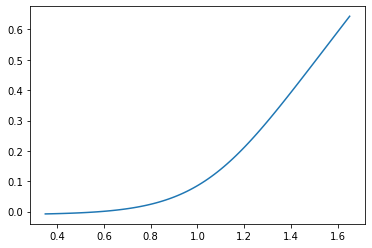

In [22]:
plt.plot(xTest, yPred)

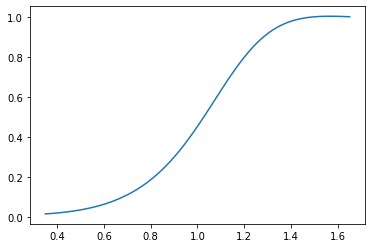

In [21]:
plt.plot(xTest,dydxPred)

/var/folders/8r/_6h7xydd2wg1psfgy9ff5sfr0000gn/T/ipykernel_27717/1448377362.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  ax[0,0].plot(spots,dydxPred, 'co', markersize=2, color='red', label='Predicted')
/var/folders/8r/_6h7xydd2wg1psfgy9ff5sfr0000gn/T/ipykernel_27717/1448377362.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  ax[0,1].plot(spots,yPred*100, 'co', markersize=2, color='red', label='Predicted')


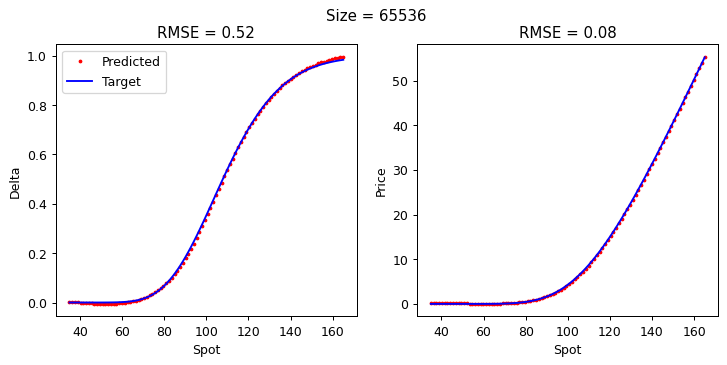

In [25]:
spots = np.linspace(35, 165, 100).reshape((-1, 1))

fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)

ax[0,0].plot(spots,dydxPred, 'co', markersize=2, color='red', label='Predicted')
ax[0,0].plot(spots,dydxTest, color='blue', label='Target')

ax[0,1].plot(spots,yPred*100, 'co', markersize=2, color='red', label='Predicted')
ax[0,1].plot(spots,yTest*100, color='blue', label='Target')

ax[0,0].set_ylabel("Delta")
ax[0,1].set_ylabel("Price")

ax[0,0].set_xlabel("Spot")
ax[0,1].set_xlabel("Spot")

errors = 100 * (dydxPred - dydxTest)
rmse = np.sqrt((errors ** 2).mean(axis=0))

t = "RMSE = %.2f" % rmse

ax[0,0].set_title(t)

errors = 100 * (yPred - yTest)
rmse = np.sqrt((errors ** 2).mean(axis=0)); rmse

t = "RMSE = %.2f" % rmse

ax[0,1].set_title(t)

t = "Size = %.0f" % size

plt.suptitle(t)

ax[0,0].legend()

plt.show()